# Import OS

In [233]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# Import libraries

In [234]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

# Store every image in an array

In [235]:
data_dir = (r'/kaggle/input/brain-tumor-classification-mri/Training/')
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
for i in categories:
    path = os.path.join(data_dir, i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))       

# Resize each image to same size for fast processing

In [236]:
img_size = 128
image_array = cv2.resize(img_array, (img_size,img_size))

In [237]:
gt1 = cv2.imread('../input/brain-tumor-classification-mri/Training/glioma_tumor/gg (1).jpg')
mt1 = cv2.imread('../input/brain-tumor-classification-mri/Training/meningioma_tumor/m (10).jpg')
nt1 = cv2.imread('../input/brain-tumor-classification-mri/Training/no_tumor/1.jpg')
pt1 = cv2.imread('../input/brain-tumor-classification-mri/Training/pituitary_tumor/p (151).jpg')

# Example of Glioma Tumor

(-0.5, 511.5, 511.5, -0.5)

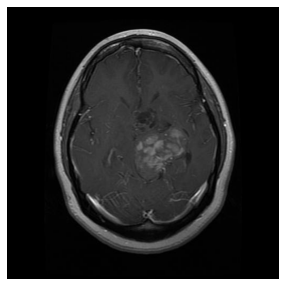

In [239]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(gt1)
plt.axis('off')

# Example of Meningioma Tumor

(-0.5, 511.5, 511.5, -0.5)

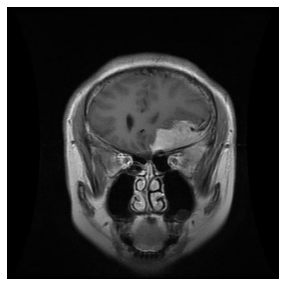

In [240]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(mt1)
plt.axis('off')

# Example of No Tumor

(-0.5, 349.5, 349.5, -0.5)

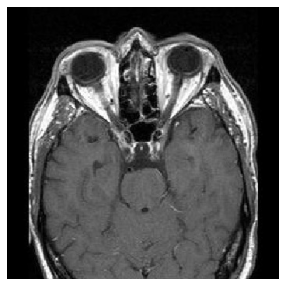

In [241]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(nt1)
plt.axis('off')

# Example of Pituitary Tumor

(-0.5, 511.5, 511.5, -0.5)

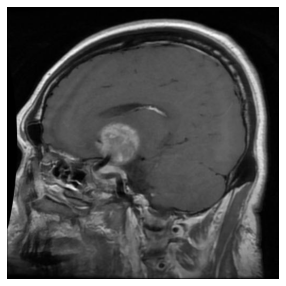

In [242]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(pt1)
plt.axis('off')

# Convert each image to grayscale and append into an array

In [218]:
train_data = []

for i in categories:
    train_path = os.path.join(data_dir,i)
    tag = categories.index(i)
    for img in os.listdir(train_path):
        try:
            image_arr = cv2.imread(os.path.join(train_path , img), cv2.IMREAD_GRAYSCALE)
            new_image_array = cv2.resize(image_arr, (img_size,img_size))
            train_data.append([new_image_array , tag])
        except Exception as e:
            pass

# Split the features and target in to X and y

In [219]:
X = []
y = []
for i,j in train_data:
    X.append(i)
    y.append(j)
X = np.array(X).reshape(-1,img_size,img_size)
print(X.shape)
X = X/255.0  
X = X.reshape(-1,128,128,1)

(2870, 128, 128)


# One-Hot encode the target column 

In [220]:
from keras.utils.np_utils import to_categorical   

y_enc = to_categorical(y, num_classes = 4)

# Split the data into Train, Validation and Test dataset (80%-10%-10%)

In [221]:
X_train , X_test, y_train, y_test = train_test_split(X , y_enc , test_size = 0.1, random_state = 42)
X_train , X_val, y_train, y_val = train_test_split(X_train , y_train , test_size = 0.1, random_state = 42)

# Import keras' functions to create CNN model

In [228]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

model = Sequential()


model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (128,128,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(4, activation = "softmax"))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 20

es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience = 3
)

batch_size = 16
imggen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=True,  
        vertical_flip=False)

# Fit the model with Train and Validation datatsets

In [229]:
imggen.fit(X_train)
history = model.fit_generator(imggen.flow(X_train,y_train,batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              callbacks = [es])    

Epoch 1/20
145/145 [==============================] - 2s 14ms/step - loss: 1.1808 - accuracy: 0.4549 - val_loss: 0.9750 - val_accuracy: 0.5792
Epoch 2/20
145/145 [==============================] - 2s 13ms/step - loss: 0.8365 - accuracy: 0.6473 - val_loss: 0.6995 - val_accuracy: 0.6757
Epoch 3/20
145/145 [==============================] - 2s 14ms/step - loss: 0.7199 - accuracy: 0.6963 - val_loss: 0.6510 - val_accuracy: 0.6873
Epoch 4/20
145/145 [==============================] - 2s 13ms/step - loss: 0.6505 - accuracy: 0.7288 - val_loss: 0.7870 - val_accuracy: 0.6332
Epoch 5/20
145/145 [==============================] - 2s 14ms/step - loss: 0.5774 - accuracy: 0.7630 - val_loss: 0.6031 - val_accuracy: 0.7529
Epoch 6/20
145/145 [==============================] - 2s 14ms/step - loss: 0.5015 - accuracy: 0.7955 - val_loss: 0.6078 - val_accuracy: 0.6950
Epoch 7/20
145/145 [==============================] - 2s 13ms/step - loss: 0.4388 - accuracy: 0.8150 - val_loss: 0.5788 - val_accuracy: 0.7490

# Plot the Loss vs Epochs graph to visualize loss at each epoch

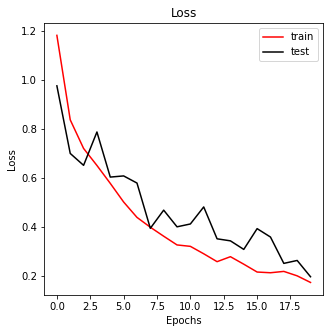

In [243]:
plt.plot(history.history["loss"],c = "red")
plt.plot(history.history["val_loss"],c = "black")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

# Plot Accuracy vs Epoch to visualize accuracy at each epoch

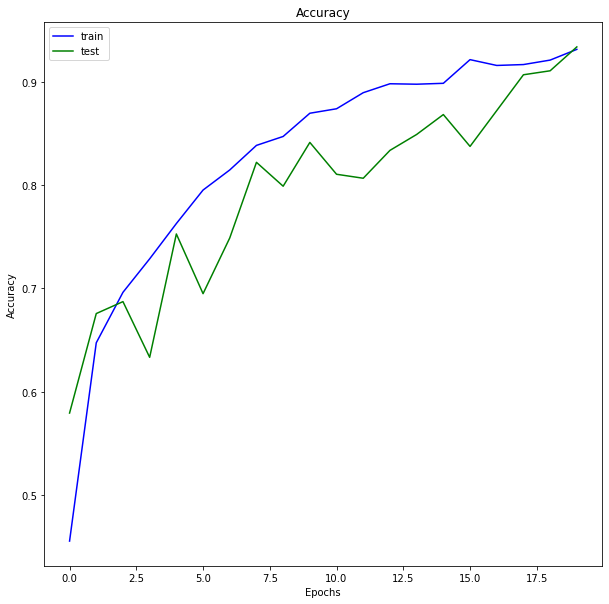

In [231]:
plt.plot(history.history["accuracy"],c = "blue")
plt.plot(history.history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.rcParams["figure.figsize"] = (50,50)
plt.legend(["train", "test"])

# Accuracy of Test Dataset

In [244]:
score = model.evaluate(X_test, y_test, verbose = 0)
score[1]

0.9233449697494507